# Preparation of dataset with H3 indexes from ecological and bathymetry data
Here I take some ecological data from Copernicus (o2, nppv, chl) for 12 months in ncdf format and bathymetry from Gebco in geotiff. I aggregated this data in h3 cells and tried to visualise data in folium and prepare geojson.   
Final file i use to dashboard prepared with dash-leaflet and plotly dash.

In [1]:
import branca
import datetime
import geojson
import geopandas as gpd
import folium
import json
import h3
import h3pandas
import netCDF4
import os
import pandas as pd
import plotly.express as px
import rasterio
import xarray as xr
import warnings

from folium.plugins import MousePosition
from branca.colormap import linear
from rasterio.plot import show

warnings.filterwarnings('ignore')

In [2]:
path = 'C:/Users/v.kozlovskiy/Desktop/_dash_hex_new_test/_dash_hex_new_test_var_03/'

In [3]:
os.chdir(path)
os.getcwd()

'C:\\Users\\v.kozlovskiy\\Desktop\\_dash_hex_new_test\\_dash_hex_new_test_var_03'

### opening copernicus dataset

In [4]:
way = path + 'global-analysis-forecast-bio-001-028-monthly_1700858898003.nc'

In [5]:
ds = xr.open_dataset(way)
ds

<xarray.Dataset>
Dimensions:    (time: 13, depth: 3, latitude: 21, longitude: 31)
Coordinates:
  * depth      (depth) float32 0.494 1.541 2.646
  * latitude   (latitude) float32 75.0 75.25 75.5 75.75 ... 79.5 79.75 80.0
  * time       (time) datetime64[ns] 2022-10-16T12:00:00 ... 2023-10-16T12:00:00
  * longitude  (longitude) float32 10.0 10.25 10.5 10.75 ... 17.0 17.25 17.5
Data variables:
    o2         (time, depth, latitude, longitude) float32 ...
    chl        (time, depth, latitude, longitude) float32 ...
    nppv       (time, depth, latitude, longitude) float32 ...
Attributes: (12/15)
    title:                         Monthly mean fields for product GLOBAL_ANA...
    references:                    http://marine.copernicus.eu
    credit:                        E.U. Copernicus Marine Service Information...
    licence:                       http://marine.copernicus.eu/services-portf...
    contact:                       servicedesk.cmems@mercator-ocean.eu
    producer:                      CMEMS - Global Monitoring and Forecasting ...
    ...                            ...
    source:                        MERCATOR BIOMER4V2R1
    product_user_manual:           http://marine.copernicus.eu/documents/PUM/...
    quality_information_document:  http://marine.copernicus.eu/documents/QUID...
    _CoordSysBuilder:              ucar.nc2.dataset.conv.CF1Convention
    comment:                       
    history:                       Data extracted from dataset http://localho...

In [6]:
ds_col = netCDF4.Dataset(way)
ds_col

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF3_CLASSIC data model, file format NETCDF3):
    title: Monthly mean fields for product GLOBAL_ANALYSIS_FORECAST_BIO_001_028
    references: http://marine.copernicus.eu
    credit: E.U. Copernicus Marine Service Information (CMEMS)
    licence: http://marine.copernicus.eu/services-portfolio/service-commitments-and-licence/
    contact: servicedesk.cmems@mercator-ocean.eu
    producer: CMEMS - Global Monitoring and Forecasting Centre
    institution: Mercator Ocean
    Conventions: CF-1.6
    area: GLOBAL
    source: MERCATOR BIOMER4V2R1
    product_user_manual: http://marine.copernicus.eu/documents/PUM/CMEMS-GLO-PUM-001-028.pdf
    quality_information_document: http://marine.copernicus.eu/documents/QUID/CMEMS-GLO-QUID-001-028.pdf
    _CoordSysBuilder: ucar.nc2.dataset.conv.CF1Convention
    comment: 
    history: Data extracted from dataset http://localhost:8080/thredds/dodsC/global-analysis-forecast-bio-001-028-monthly
    dimensions

In [7]:
params = []
for param in list(ds_col.variables.keys()):
    params.append(param)
params

['o2', 'depth', 'chl', 'latitude', 'time', 'nppv', 'longitude']

In [8]:
ds = ds.to_dataframe()

In [9]:
ds

o2       chl  \
time                depth    latitude longitude                         
2022-10-16 12:00:00 0.494025 75.0     10.00      306.149261  0.210586   
                                      10.25      306.289825  0.210164   
                                      10.50      306.350159  0.211639   
                                      10.75      306.385498  0.212657   
                                      11.00      306.408081  0.213789   
...                                                     ...       ...   
2023-10-16 12:00:00 2.645669 80.0     16.50      325.173920  0.162984   
                                      16.75      326.235260  0.159635   
                                      17.00      327.606110  0.158223   
                                      17.25      328.753937  0.158422   
                                      17.50      330.540558  0.164447   

                                                     nppv  
time                depth    latitude longitude            
2022-10-16 12:00:00 0.494025 75.0     10.00      0.566124  
                                      10.25      0.569533  
                                      10.50      0.572488  
                                      10.75      0.575049  
                                      11.00      0.582505  
...                                                   ...  
2023-10-16 12:00:00 2.645669 80.0     16.50      0.039663  
                                      16.75      0.049888  
                                      17.00      0.058953  
                                      17.25      0.065236  
                                      17.50      0.071555  

[25389 rows x 3 columns]

In [10]:
# make index columns as data columns
a = ds.index.to_frame()
for i in a.columns:
    ds[i] = a[i]
ds = ds.reset_index(drop=True)
ds = ds.rename(columns={'latitude': 'lat', 'longitude': 'lon'})
ds

o2       chl      nppv                time     depth   lat  \
0      306.149261  0.210586  0.566124 2022-10-16 12:00:00  0.494025  75.0   
1      306.289825  0.210164  0.569533 2022-10-16 12:00:00  0.494025  75.0   
2      306.350159  0.211639  0.572488 2022-10-16 12:00:00  0.494025  75.0   
3      306.385498  0.212657  0.575049 2022-10-16 12:00:00  0.494025  75.0   
4      306.408081  0.213789  0.582505 2022-10-16 12:00:00  0.494025  75.0   
...           ...       ...       ...                 ...       ...   ...   
25384  325.173920  0.162984  0.039663 2023-10-16 12:00:00  2.645669  80.0   
25385  326.235260  0.159635  0.049888 2023-10-16 12:00:00  2.645669  80.0   
25386  327.606110  0.158223  0.058953 2023-10-16 12:00:00  2.645669  80.0   
25387  328.753937  0.158422  0.065236 2023-10-16 12:00:00  2.645669  80.0   
25388  330.540558  0.164447  0.071555 2023-10-16 12:00:00  2.645669  80.0   

         lon  
0      10.00  
1      10.25  
2      10.50  
3      10.75  
4      11.00  
...      ...  
25384  16.50  
25385  16.75  
25386  17.00  
25387  17.25  
25388  17.50  

[25389 rows x 7 columns]

In [11]:
# round time to month and select surface layer in data
ds['time'] = pd.to_datetime(ds['time']).dt.to_period('M').dt.to_timestamp()
ds = ds.loc[ds['depth'] == ds['depth'].min()]
ds

o2       chl      nppv       time     depth   lat    lon
0      306.149261  0.210586  0.566124 2022-10-01  0.494025  75.0  10.00
1      306.289825  0.210164  0.569533 2022-10-01  0.494025  75.0  10.25
2      306.350159  0.211639  0.572488 2022-10-01  0.494025  75.0  10.50
3      306.385498  0.212657  0.575049 2022-10-01  0.494025  75.0  10.75
4      306.408081  0.213789  0.582505 2022-10-01  0.494025  75.0  11.00
...           ...       ...       ...        ...       ...   ...    ...
24082  325.189972  0.162987  0.039663 2023-10-01  0.494025  80.0  16.50
24083  326.259460  0.159640  0.049889 2023-10-01  0.494025  80.0  16.75
24084  327.639648  0.158233  0.058955 2023-10-01  0.494025  80.0  17.00
24085  328.794128  0.158437  0.065239 2023-10-01  0.494025  80.0  17.25
24086  330.588898  0.164465  0.071560 2023-10-01  0.494025  80.0  17.50

[8463 rows x 7 columns]

In [12]:
# view on copernicus data by points on map 
fig = px.scatter_mapbox(ds,
                        lat=ds['lat'],
                        lon=ds['lon'],
                        hover_name=ds['o2'],
                        zoom=3,
                        mapbox_style = 'open-street-map')
fig.show()

In [13]:
# function to take h3-index from coordinates 

def convert_to_h3(lat, lon, res):
    h3_index = h3.geo_to_h3(lat, lon, res)
    return h3_index


def h3_to_table(row):
    lat = row['lat']
    lon = row['lon']
    h3_index = convert_to_h3(lat, lon, 4)
    return h3_index

In [14]:
ds['h3'] = ds.apply(h3_to_table, axis=1)
ds

o2       chl      nppv       time     depth   lat    lon  \
0      306.149261  0.210586  0.566124 2022-10-01  0.494025  75.0  10.00   
1      306.289825  0.210164  0.569533 2022-10-01  0.494025  75.0  10.25   
2      306.350159  0.211639  0.572488 2022-10-01  0.494025  75.0  10.50   
3      306.385498  0.212657  0.575049 2022-10-01  0.494025  75.0  10.75   
4      306.408081  0.213789  0.582505 2022-10-01  0.494025  75.0  11.00   
...           ...       ...       ...        ...       ...   ...    ...   
24082  325.189972  0.162987  0.039663 2023-10-01  0.494025  80.0  16.50   
24083  326.259460  0.159640  0.049889 2023-10-01  0.494025  80.0  16.75   
24084  327.639648  0.158233  0.058955 2023-10-01  0.494025  80.0  17.00   
24085  328.794128  0.158437  0.065239 2023-10-01  0.494025  80.0  17.25   
24086  330.588898  0.164465  0.071560 2023-10-01  0.494025  80.0  17.50   

                    h3  
0      8401719ffffffff  
1      840171dffffffff  
2      840171dffffffff  
3      840171dffffffff  
4      840171dffffffff  
...                ...  
24082  8400299ffffffff  
24083  8400299ffffffff  
24084  8400299ffffffff  
24085  8400299ffffffff  
24086  8400299ffffffff  

[8463 rows x 8 columns]

In [15]:
# aggregation of copernicus data by time and h3

cop = ds.groupby(['h3', 'time'])['o2', 'chl', 'nppv'].agg(['mean'])
b = cop.index.to_frame()
b.columns = cop.index.names
for x in b.columns:
    cop[x] = b[x]
cop = cop.reset_index(drop=True)
cop.columns = ['o2', 'chl', 'nppv', 'h3', 'time']
cop = cop.dropna()
cop = cop.reset_index(drop=True)
cop

o2       chl       nppv               h3       time
0    319.521973  0.152807   0.080886  8400299ffffffff 2022-10-01
1    318.766968  0.072199   0.000000  8400299ffffffff 2022-11-01
2    327.913177  0.046126   0.000000  8400299ffffffff 2022-12-01
3    335.316040  0.036448   0.000000  8400299ffffffff 2023-01-01
4    338.146545  0.030495   0.000344  8400299ffffffff 2023-02-01
..          ...       ...        ...              ...        ...
931  325.642273  1.364602  23.179731  840173dffffffff 2023-06-01
932  316.980438  1.134671  20.101772  840173dffffffff 2023-07-01
933  303.016663  0.622807  10.601805  840173dffffffff 2023-08-01
934  297.492706  0.435280   4.262773  840173dffffffff 2023-09-01
935  302.480408  0.189395   0.336642  840173dffffffff 2023-10-01

[936 rows x 5 columns]

#### opening geotiff

In [16]:
geotif = path + 'gebco_2023_n80.0_s75.0_w10.0_e17.5.tif'

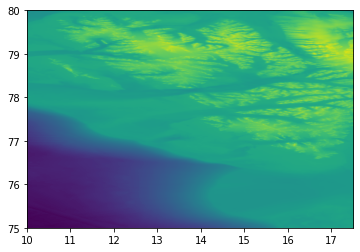

<AxesSubplot:>

In [17]:
src = rasterio.open(geotif)
show(src)

In [18]:
img = src.read(1)
img

array([[ -480,  -480,  -480, ...,  -344,  -347,  -350],
       [ -480,  -480,  -480, ...,  -329,  -330,  -331],
       [ -479,  -479,  -479, ...,  -323,  -323,  -323],
       ...,
       [-2530, -2530, -2531, ...,  -127,  -125,  -124],
       [-2526, -2527, -2527, ...,  -127,  -127,  -126],
       [-2525, -2525, -2526, ...,  -122,  -121,  -121]], dtype=int16)

In [19]:
# fuction to make datafile with coordinates and depth
def geotiff_to_xyz(way):
    dataarray = xr.open_rasterio(way)
    df = dataarray[0].to_pandas()
    lat = pd.Series(pd.to_numeric(list(df.index) * df.shape[1])).sort_values(ascending=False)
    lon = pd.to_numeric(list(df.columns) * df.shape[0])
    depth = df.values.flatten()
    ds = pd.DataFrame({'lat': lat, 'lon': lon, 'value': depth})
    return ds

In [20]:
%%time
# make table with h3 indexes and bathymetry data
depth_gebco = geotiff_to_xyz(geotif)
depth_gebco['h3'] = depth_gebco.apply(h3_to_table, axis=1)
depth_gebco

CPU times: total: 18.9 s
Wall time: 18.9 s


lat        lon  value               h3
0        79.997917  10.002083   -480  84015a3ffffffff
811200   79.997917  10.006250   -480  84015a3ffffffff
712800   79.997917  10.010417   -480  84015a3ffffffff
714000   79.997917  10.014583   -480  84015a3ffffffff
715200   79.997917  10.018750   -480  84015a3ffffffff
...            ...        ...    ...              ...
263999   75.002083  17.481250   -123  840172dffffffff
14399    75.002083  17.485417   -122  840172dffffffff
1256399  75.002083  17.489583   -122  840172dffffffff
119999   75.002083  17.493750   -121  840172dffffffff
2159999  75.002083  17.497917   -121  840172dffffffff

[2160000 rows x 4 columns]

In [21]:
# aggregation of depth by h3 cells
params = ['value']
depth_gebco_g = depth_gebco.groupby(['h3'])[params].agg(['mean'])
b = depth_gebco_g.index.to_frame()
b.columns = depth_gebco_g.index.names
for x in b.columns:
    depth_gebco_g[x] = b[x]
depth_gebco_g = depth_gebco_g.reset_index(drop=True)
params.append('h3')
depth_gebco_g.columns = params
depth_gebco_g = depth_gebco_g.dropna()
depth_gebco_g

value               h3
0    145.353682  8400299ffffffff
1    829.711704  84002d1ffffffff
2    376.150479  84002d3ffffffff
3    525.843387  84002d7ffffffff
4    601.980270  84002d9ffffffff
..          ...              ...
83 -1084.117367  8401737ffffffff
84 -1641.512295  8401739ffffffff
85 -2035.324175  840173bffffffff
86  -596.885953  840173dffffffff
87 -2505.000000  8401757ffffffff

[88 rows x 2 columns]

In [22]:
depth_gebco_g.columns=['depth_gebco', 'h3']

In [23]:
# join eco columns with depth
cop2 = cop.merge(depth_gebco_g, on='h3', how='outer')

In [24]:
cop2

o2       chl      nppv               h3       time  depth_gebco
0    319.521973  0.152807  0.080886  8400299ffffffff 2022-10-01   145.353682
1    318.766968  0.072199  0.000000  8400299ffffffff 2022-11-01   145.353682
2    327.913177  0.046126  0.000000  8400299ffffffff 2022-12-01   145.353682
3    335.316040  0.036448  0.000000  8400299ffffffff 2023-01-01   145.353682
4    338.146545  0.030495  0.000344  8400299ffffffff 2023-02-01   145.353682
..          ...       ...       ...              ...        ...          ...
947         NaN       NaN       NaN  84015e5ffffffff        NaT   446.626576
948         NaN       NaN       NaN  84015e7ffffffff        NaT   701.026842
949         NaN       NaN       NaN  84015edffffffff        NaT   265.990524
950         NaN       NaN       NaN  8401725ffffffff        NaT  -172.550000
951         NaN       NaN       NaN  8401757ffffffff        NaT -2505.000000

[952 rows x 6 columns]

In [25]:
# function to connect depth values from gebco with copernicus dataframe by h3-index
def gebco_depth_to_table(row):
    for i in range(len(depth_gebco_g)):
        if row == depth_gebco_g['h3'].iloc[i]:
            return depth_gebco_g['depth_gebco'].iloc[i]

In [26]:
%%time
# it is other version of join ecology with depth - in this case will be used only depth observations in h3 used for ecology
# in dash i wan`t use previous version (all depth)
cop['depth_gebco'] = cop['h3'].apply(gebco_depth_to_table)

CPU times: total: 328 ms
Wall time: 330 ms


In [27]:
cop

o2       chl       nppv               h3       time  depth_gebco
0    319.521973  0.152807   0.080886  8400299ffffffff 2022-10-01   145.353682
1    318.766968  0.072199   0.000000  8400299ffffffff 2022-11-01   145.353682
2    327.913177  0.046126   0.000000  8400299ffffffff 2022-12-01   145.353682
3    335.316040  0.036448   0.000000  8400299ffffffff 2023-01-01   145.353682
4    338.146545  0.030495   0.000344  8400299ffffffff 2023-02-01   145.353682
..          ...       ...        ...              ...        ...          ...
931  325.642273  1.364602  23.179731  840173dffffffff 2023-06-01  -596.885953
932  316.980438  1.134671  20.101772  840173dffffffff 2023-07-01  -596.885953
933  303.016663  0.622807  10.601805  840173dffffffff 2023-08-01  -596.885953
934  297.492706  0.435280   4.262773  840173dffffffff 2023-09-01  -596.885953
935  302.480408  0.189395   0.336642  840173dffffffff 2023-10-01  -596.885953

[936 rows x 6 columns]


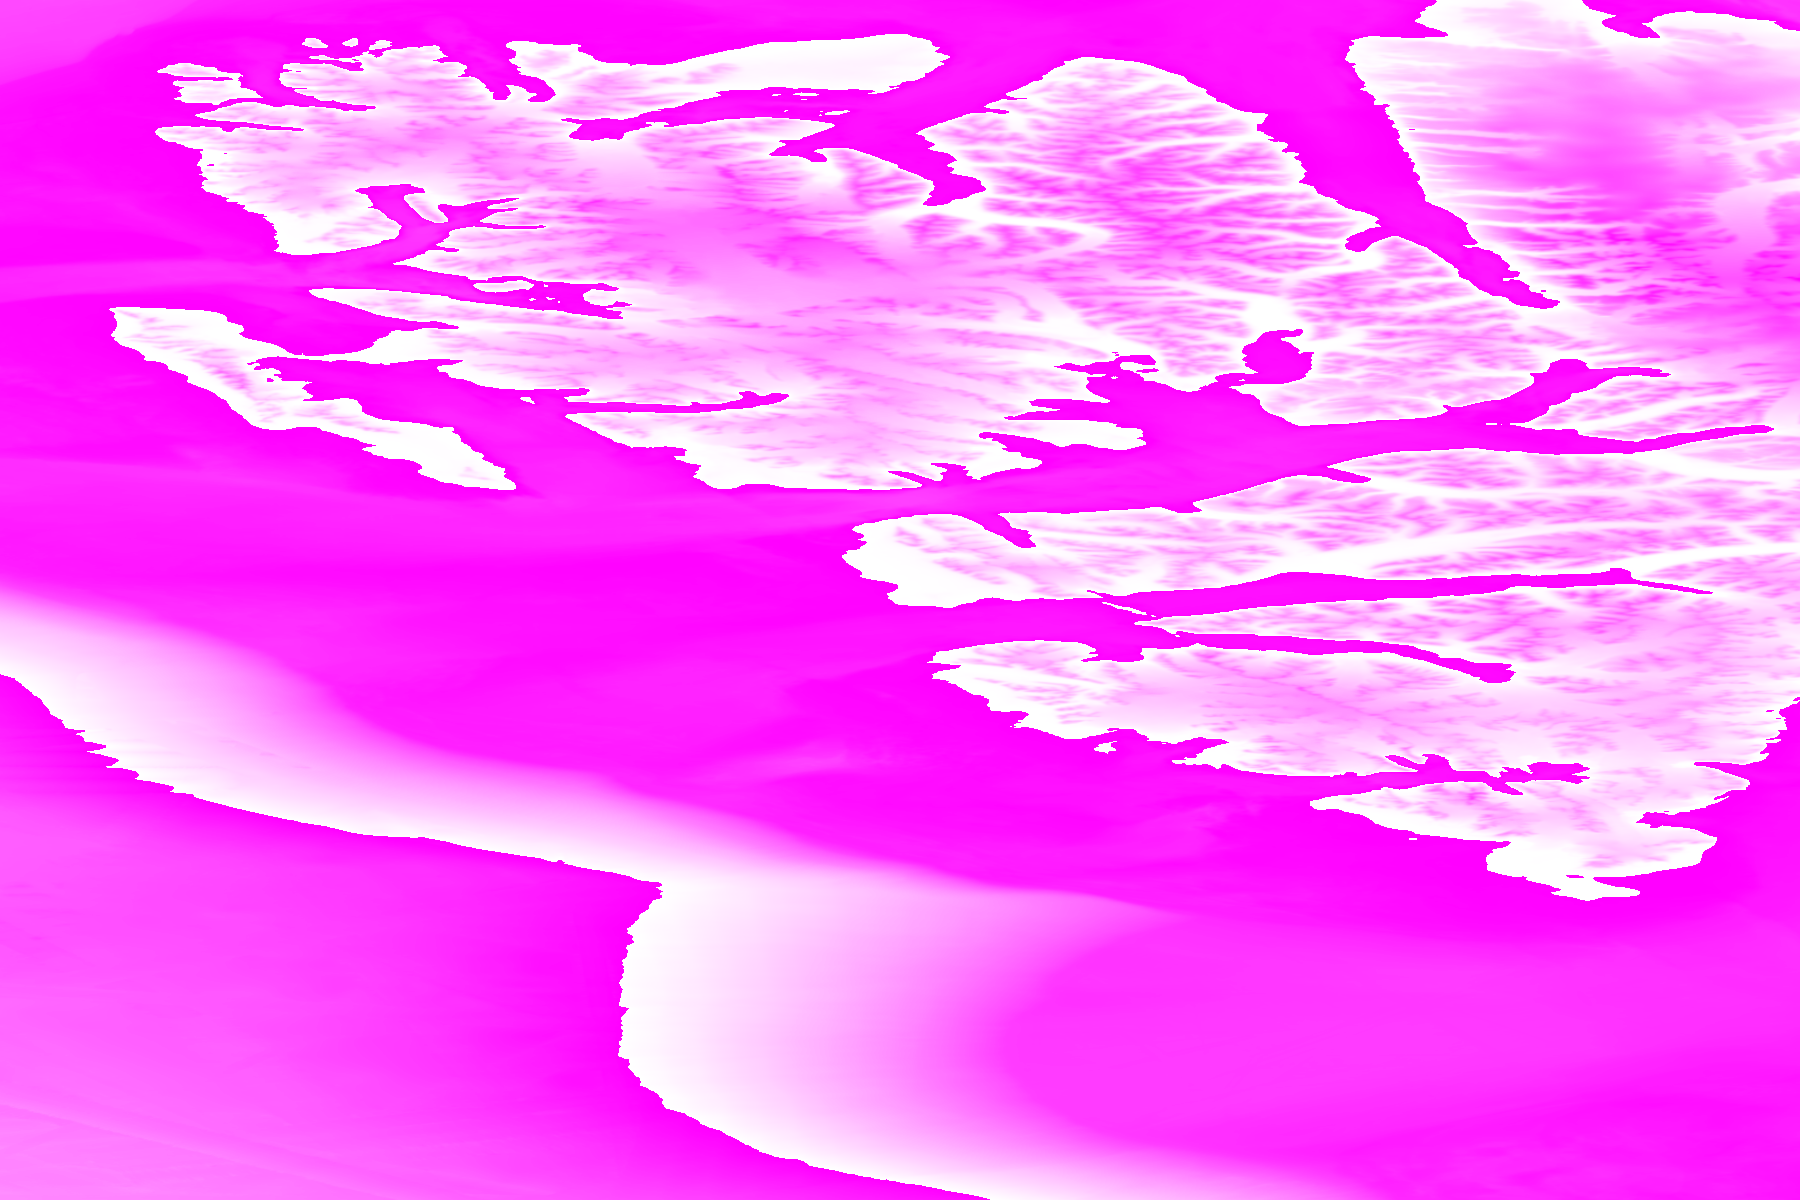

In [28]:
# drawing map with depth from gebco with hexagons and with geotiff layer

interval = depth_gebco_g['depth_gebco'].max() - depth_gebco_g['depth_gebco'].min()
colormap = branca.colormap.LinearColormap(colors=['cyan', 'green', 'yellow', 'orange','red'],
                            index=[interval * 0.1, interval * 0.2, interval * 0.3, interval * 0.6], 
                            vmin=round(depth_gebco_g['depth_gebco'].min(), 2), vmax=round(depth_gebco_g['depth_gebco'].max(), 2),
                             caption='depth')

start = 0
for i in range(len(depth_gebco_g)):
    hex_coord = h3.h3_to_geo_boundary(depth_gebco_g['h3'].iloc[i])
    meaninig_in_point = depth_gebco_g['depth_gebco'].iloc[i]
    map_center = [hex_coord[0][0], hex_coord[0][1]]
    if start == 0:
        map_h3 = folium.Map(location=map_center, zoom_start=5, crs='EPSG3857')
        start = 1
    folium.Polygon(locations=hex_coord, color='blue', fill=True, fill_color=colormap(meaninig_in_point), fill_opacity=0.6, popup=round(depth_gebco_g['depth_gebco'].iloc[i], 2), legend=True).add_to(map_h3)             
    

img_overlay = folium.raster_layers.ImageOverlay(name="Bathymetry",
                                                image=img,
                                                bounds = [[src.bounds[1], src.bounds[0]], [src.bounds[3], src.bounds[2]]],
                                                opacity=0.9,
                                                colormap = lambda x: (1, 0, 1, x),
                                                mercator_project=True,
                                                zindex=1
                                               ).add_to(map_h3)

img_overlay.add_to(map_h3)
folium.LayerControl().add_to(map_h3)

formatter = "function(num) {return L.Util.formatNum(num, 3) + ' º ';};"

MousePosition(
    position="topright",
    separator=" | ",
    empty_string="NaN",
    lng_first=True,
    num_digits=20,
    prefix="Coordinates:",
    lat_formatter=formatter,
    lng_formatter=formatter,
).add_to(map_h3)


map_h3.add_child(colormap)
map_h3.save('h3_map.html')
map_h3

0.0
39.45042419433594



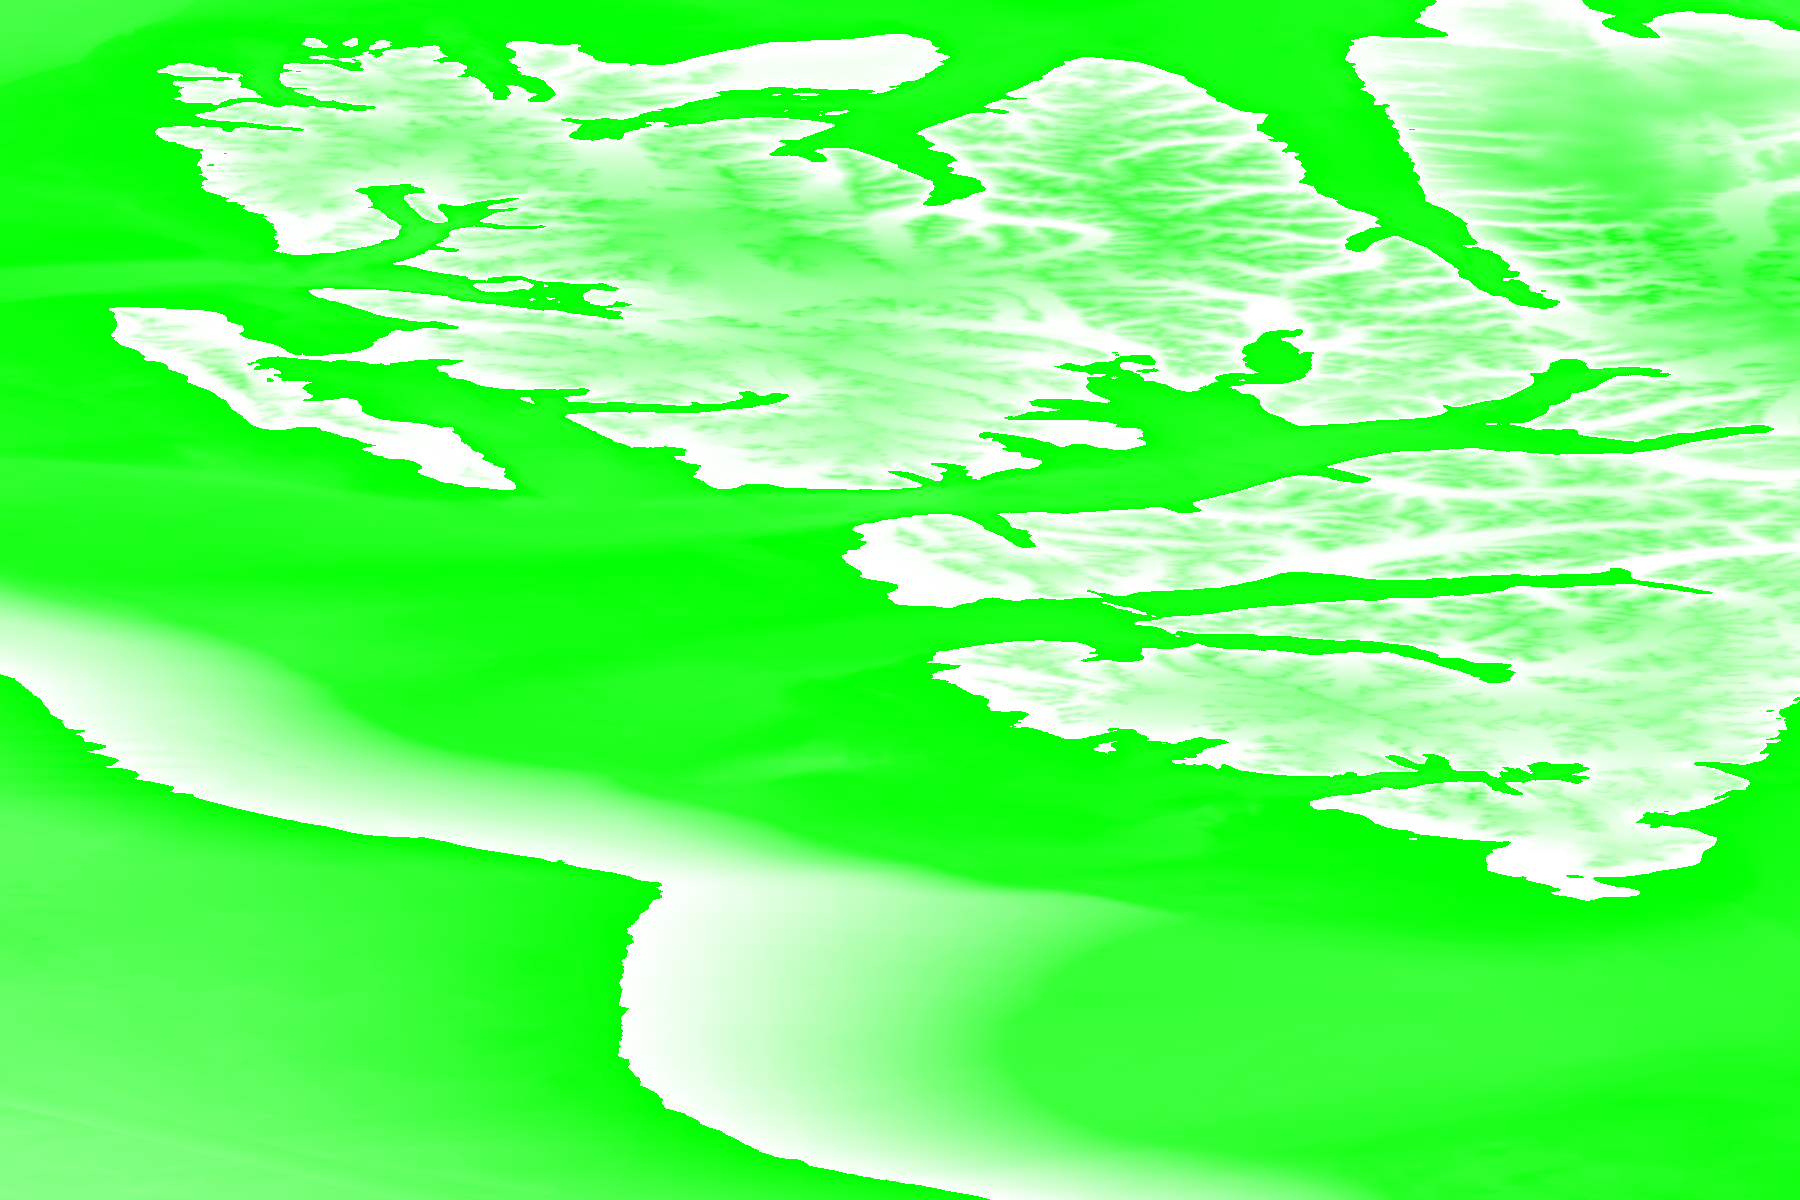

In [29]:
# drawing map with data from copernicus with hexagons and with depth geotiff layer 

interval = cop['nppv'].max() - cop['nppv'].min()
colormap = branca.colormap.LinearColormap(colors=['cyan', 'green', 'yellow', 'orange','red'],
       #                     index=[interval * 0.1, interval * 0.2, interval * 0.3, interval * 0.6], 
                            vmin=round(cop['nppv'].min(), 2), vmax=round(cop['nppv'].max(), 2),
                             caption='nppv')
print(cop['nppv'].min())
print(cop['nppv'].max())
start = 0
for i in range(len(cop)):
    hex_coord = h3.h3_to_geo_boundary(cop['h3'].iloc[i])
    meaninig_in_point = cop['nppv'].iloc[i]
    map_center = [hex_coord[0][0], hex_coord[0][1]]
    if start == 0:
        map_h3 = folium.Map(location=map_center, zoom_start=5, crs='EPSG3857')
        start = 1
    folium.Polygon(locations=hex_coord, color=colormap(meaninig_in_point), fill=True, fill_color=colormap(meaninig_in_point), fill_opacity=0.6, popup=round(cop['nppv'].iloc[i], 2), legend=True).add_to(map_h3)             
    

img_overlay = folium.raster_layers.ImageOverlay(name="Bathymetry",
                                                image=img,
                                                bounds = [[src.bounds[1], src.bounds[0]], [src.bounds[3], src.bounds[2]]],
                                                opacity=0.9,
                                                colormap = lambda x: (0, 1, 0, x),
                                                mercator_project=True,
                                                zindex=1
                                               ).add_to(map_h3)

img_overlay.add_to(map_h3)
folium.LayerControl().add_to(map_h3)

formatter = "function(num) {return L.Util.formatNum(num, 3) + ' º ';};"

MousePosition(
    position="topright",
    separator=" | ",
    empty_string="NaN",
    lng_first=True,
    num_digits=20,
    prefix="Coordinates:",
    lat_formatter=formatter,
    lng_formatter=formatter,
).add_to(map_h3)

map_h3.add_child(colormap)
map_h3.save('h3_map.html')
map_h3


In [30]:
# rename columns for more understandable names
cop2.columns = ['oxygen', 'chlorophуll', 'net_primary_production', 'h3', 'time', 'depth_gebco' ]

In [31]:
# save datafile to use in dashboard
#cop.to_csv(path + 'datafile.csv', sep=';')
cop2.to_csv(path + 'datafile.csv', sep=';')

# GeoJSON
During prepare dash I needed a better understanding of how geojson works, so here are some experiments with creating and processing geojson for use in folium visualizations.  
(in dash-leaflet the actions were slightly different, but fundamentally similar)

In [32]:
cop['geometry'] = cop['h3'].apply(lambda x: h3.h3_to_geo_boundary(x))
cop

o2       chl       nppv               h3       time  depth_gebco  \
0    319.521973  0.152807   0.080886  8400299ffffffff 2022-10-01   145.353682   
1    318.766968  0.072199   0.000000  8400299ffffffff 2022-11-01   145.353682   
2    327.913177  0.046126   0.000000  8400299ffffffff 2022-12-01   145.353682   
3    335.316040  0.036448   0.000000  8400299ffffffff 2023-01-01   145.353682   
4    338.146545  0.030495   0.000344  8400299ffffffff 2023-02-01   145.353682   
..          ...       ...        ...              ...        ...          ...   
931  325.642273  1.364602  23.179731  840173dffffffff 2023-06-01  -596.885953   
932  316.980438  1.134671  20.101772  840173dffffffff 2023-07-01  -596.885953   
933  303.016663  0.622807  10.601805  840173dffffffff 2023-08-01  -596.885953   
934  297.492706  0.435280   4.262773  840173dffffffff 2023-09-01  -596.885953   
935  302.480408  0.189395   0.336642  840173dffffffff 2023-10-01  -596.885953   

                                              geometry  
0    ((79.72341469205415, 16.934199309752138), (79....  
1    ((79.72341469205415, 16.934199309752138), (79....  
2    ((79.72341469205415, 16.934199309752138), (79....  
3    ((79.72341469205415, 16.934199309752138), (79....  
4    ((79.72341469205415, 16.934199309752138), (79....  
..                                                 ...  
931  ((75.3756197205537, 14.428745695104874), (75.5...  
932  ((75.3756197205537, 14.428745695104874), (75.5...  
933  ((75.3756197205537, 14.428745695104874), (75.5...  
934  ((75.3756197205537, 14.428745695104874), (75.5...  
935  ((75.3756197205537, 14.428745695104874), (75.5...  

[936 rows x 7 columns]

In [33]:
# Define an empty list to store features
features = []

# Read pandas df and create GeoJSON features

for i in range(len(cop)):
    h3_ind = cop['h3'].iloc[i]
    geometry = cop['geometry'].iloc[i]
#    time = str(cop['time'].iloc[i])
    depth = float(cop['depth_gebco'].iloc[i])              
    chl = float(cop['chl'].iloc[i])  
    o2 = float(cop['o2'].iloc[i])  
    nppv = float(cop['nppv'].iloc[i])  
        # Create a GeoJSON feature
    feature = {
        "type": "Feature",
        "geometry": {
            "type": "Polygon",
            "coordinates": [geometry]
        },
        "properties": {
            "name": h3_ind,
 #           "time": time,
            "depth": depth,
            "o2": o2,
            "chl": chl,
            "nppv": nppv
                # Add other properties as needed
        }
    }
       
        # Append the feature to the features list
    features.append(feature)

# Create a GeoJSON object
geojson_data = {
    "type": "FeatureCollection",
    "features": features
}

In [34]:
# Save GeoJSON data to a file or use it as needed
with open(path + 'cop.geojson', 'w') as output_file:
    json.dump(geojson_data, output_file, indent=2)

In [35]:
# here i tried to open geojson with different way (with pandas, geopandas)
a1 = gpd.read_file(path + 'cop.geojson')
a = pd.read_json(path + 'cop.geojson')
display(a)
display(a1)

type                                           features
0    FeatureCollection  {'type': 'Feature', 'geometry': {'type': 'Poly...
1    FeatureCollection  {'type': 'Feature', 'geometry': {'type': 'Poly...
2    FeatureCollection  {'type': 'Feature', 'geometry': {'type': 'Poly...
3    FeatureCollection  {'type': 'Feature', 'geometry': {'type': 'Poly...
4    FeatureCollection  {'type': 'Feature', 'geometry': {'type': 'Poly...
..                 ...                                                ...
931  FeatureCollection  {'type': 'Feature', 'geometry': {'type': 'Poly...
932  FeatureCollection  {'type': 'Feature', 'geometry': {'type': 'Poly...
933  FeatureCollection  {'type': 'Feature', 'geometry': {'type': 'Poly...
934  FeatureCollection  {'type': 'Feature', 'geometry': {'type': 'Poly...
935  FeatureCollection  {'type': 'Feature', 'geometry': {'type': 'Poly...

[936 rows x 2 columns]

name       depth          o2       chl       nppv  \
0    8400299ffffffff  145.353682  319.521973  0.152807   0.080886   
1    8400299ffffffff  145.353682  318.766968  0.072199   0.000000   
2    8400299ffffffff  145.353682  327.913177  0.046126   0.000000   
3    8400299ffffffff  145.353682  335.316040  0.036448   0.000000   
4    8400299ffffffff  145.353682  338.146545  0.030495   0.000344   
..               ...         ...         ...       ...        ...   
931  840173dffffffff -596.885953  325.642273  1.364602  23.179731   
932  840173dffffffff -596.885953  316.980438  1.134671  20.101772   
933  840173dffffffff -596.885953  303.016663  0.622807  10.601805   
934  840173dffffffff -596.885953  297.492706  0.435280   4.262773   
935  840173dffffffff -596.885953  302.480408  0.189395   0.336642   

                                              geometry  
0    POLYGON ((79.72341 16.93420, 79.85114 17.95635...  
1    POLYGON ((79.72341 16.93420, 79.85114 17.95635...  
2    POLYGON ((79.72341 16.93420, 79.85114 17.95635...  
3    POLYGON ((79.72341 16.93420, 79.85114 17.95635...  
4    POLYGON ((79.72341 16.93420, 79.85114 17.95635...  
..                                                 ...  
931  POLYGON ((75.37562 14.42875, 75.50034 15.10002...  
932  POLYGON ((75.37562 14.42875, 75.50034 15.10002...  
933  POLYGON ((75.37562 14.42875, 75.50034 15.10002...  
934  POLYGON ((75.37562 14.42875, 75.50034 15.10002...  
935  POLYGON ((75.37562 14.42875, 75.50034 15.10002...  

[936 rows x 6 columns]

In [36]:
# here I changed the latitude and longitude because h3 arranged them in a different order than in folium and dash-leaflet
# probably there is a simpler way, but here I used this way 

# Load GeoJSON file
with open(path + 'cop.geojson', 'r') as f:
    geojson_data = json.load(f)

# Reorder coordinates in each polygon
for feature in geojson_data['features']:
    if feature['geometry']['type'] == 'Polygon':
        # Assuming coordinates are [longitude, latitude]
        for coords in feature['geometry']['coordinates']:
            coords[0][0], coords[0][1] = coords[0][1], coords[0][0]
            coords[1][0], coords[1][1] = coords[1][1], coords[1][0]
            coords[2][0], coords[2][1] = coords[2][1], coords[2][0]
            coords[3][0], coords[3][1] = coords[3][1], coords[3][0]
            coords[4][0], coords[4][1] = coords[4][1], coords[4][0]
            coords[5][0], coords[5][1] = coords[5][1], coords[5][0]            

# Save the modified GeoJSON file
with open(path + 'cop.geojson', 'w') as f:
    json.dump(geojson_data, f)

In [37]:
# here i make visualistion of hexagon in folium using geojson

with open(path + 'cop.geojson') as f:
    gj = geojson.load(f)

colormap = linear.YlGn_09.scale(
    a1['o2'].min(), a1['o2'].max()
)

m = folium.Map([76, 14], zoom_start=4)

folium.GeoJson(gj, 
               style_function=lambda feature: {
                    "fillColor": colormap(feature["properties"]["o2"]),
                    "color": colormap(feature["properties"]["o2"]),
                    "weight": 2,
                    "dashArray": "5, 5",
                    "fillOpacity": 0.7,
                    "Opacity" : 0.7,
    },
).add_to(m)


formatter = "function(num) {return L.Util.formatNum(num, 3) + ' º ';};"

MousePosition(
    position="topright",
    separator=" | ",
    empty_string="NaN",
    lng_first=True,
    num_digits=20,
    prefix="Coordinates:",
    lat_formatter=formatter,
    lng_formatter=formatter,
).add_to(m)

colormap.add_to(m)
m